In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

import gensim
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt 
from time import time
import tensorflow.keras

#!pip install textblob
#!pip install tweepy
import sys,tweepy,csv,re
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import unicodedata
from autocorrect import Speller

c:\users\kushagra\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
test_data = pd.read_csv("data/preprocessed_train.csv")
test_data.text = test_data.selected_text.map(lambda x:str(x))
test_data.sentiment = test_data.sentiment.astype("category")
test_data.sentiment = test_data.sentiment.cat.codes

In [3]:
#tokenizing and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(test_data.text.values)

maxlen = 100

In [4]:
#Load the Model
model = load_model('cnn_model.h5')

In [5]:
def preprocessTweets(t):
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    all_stopwords.remove('no')
    
    url = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    t = map(lambda x:str(x).lower(), t) #lower case
    t = map(lambda x:re.sub(r"\b[^\s]+@[^\s]+[.][^\s]+\b", "", x), t) #email
    t = map(lambda x:re.sub(url, "", x), t) #url
    t = map(lambda x:re.sub(r'(\d[a-zA-Z]{0,})', "", x), t) #numbers [^a-zA-z.,!?/:;\"\'\s]
    t = map(lambda x:re.sub(r'^\s*|\s\s*', ' ', x).strip(), t) #white space
    t = map(lambda x:''.join([c for c in x if c not in string.punctuation]), t) #punctuations
    t = map(lambda x:re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', x), t) #special char
    t = map(lambda x:unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'), t) #unicode
    
    spell = Speller(lang="en")
    tokenizer = RegexpTokenizer(r'\w+')

    t = map(lambda x:tokenizer.tokenize(x), t)  #remove punctuation and tokenize
    t = map(lambda x:[spell(i) for i in x], t)  #spell check
    t = list(t)
    return [ " ".join([word for word in x[2:] if word not in all_stopwords ]) for x in list(t)]

In [6]:
tweets = []
tweetText = []
mapping={0:"Negative",1:"Neutral",2:"Positive"}

In [7]:
# class SentimentAnalysis:

def DownloadData():
    # authenticating
    consumerKey =''
    consumerSecret =''
    accessToken = ''
    accessTokenSecret = ''
    auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
    auth.set_access_token(accessToken, accessTokenSecret)
    api = tweepy.API(auth)
    
    searchTerm = input("Enter Keyword/Tag to search about: ")
    NoOfTerms = int(input("Enter how many tweets to search: "))

    # searching for tweets
    tweets = tweepy.Cursor(api.search, q=searchTerm, lang = "en").items(NoOfTerms)

    # Open/create a file to append data to
    csvFile = open('result.csv', 'a')

    csvWriter = csv.writer(csvFile)

    polarity = 0
    positive = 0
    negative = 0
    neutral = 0

    tweetText = []
    
    for tweet in tweets:
        tweetText.append(tweet.text)
    
    tweetText = preprocessTweets(tweetText)
    print(tweetText)
    
    for tweet in tweetText:
        X_test1 = tokenizer.texts_to_sequences([str(cleanTweet(tweet).encode('utf-8'))])
        X_test1 = pad_sequences(X_test1, padding='post', maxlen = maxlen)
        analysis = np.argmax(model.predict(X_test1), axis = -1)[0]
        print("[" +mapping[analysis]+"] Sentence: "+tweet)
        
        polarity += analysis
        if (analysis == 0): 
            negative += 1
        elif (analysis == 1):
            neutral += 1
        elif (analysis == 2):
            positive += 1
    csvWriter.writerow(tweetText)
    csvFile.close()
    positive = percentage(positive, NoOfTerms)
    negative = percentage(negative, NoOfTerms)
    neutral = percentage(neutral, NoOfTerms)

    # finding average reaction
    polarity = polarity / NoOfTerms

    
    print("How people are reacting on " + searchTerm + " by analyzing " + str(NoOfTerms) + " tweets.")
    print()
    print("General Report: ")

    m=max(positive,negative,neutral)

    if (m==negative):
        print("Negative")
    elif (m==neutral):
        print("Neutral")
    else:
        print("Positive")

    print()
    print("Detailed Report: ")
    print(str(positive) + "% people thought it was positive")
    print(str(negative) + "% people thought it was negative")
    print(str(neutral) + "% people thought it was neutral")

    plotPieChart(positive, negative, neutral, searchTerm, NoOfTerms)


def cleanTweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", tweet).split())

# function to calculate percentage
def percentage(part, whole):
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')

def plotPieChart(positive, negative, neutral, searchTerm, noOfSearchTerms):
    labels = ['Positive [' + str(positive) + '%]', 'Neutral [' + str(neutral) + '%]', 'Negative [' + str(negative) + '%]']
    sizes = [positive, neutral, negative]
    colors = ['yellowgreen', 'gold', 'red']
    patches, texts = plt.pie(sizes, colors=colors, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.title('How people are reacting on ' + searchTerm + ' by analyzing ' + str(noOfSearchTerms) + ' Tweets.')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

Enter Keyword/Tag to search about: covaxin
Enter how many tweets to search: 80
['since yesterday unable login coin applicationwebsite pops generate top failed three peoples dos', 'vaccines greatest global reach countries oxfordastrazeneca countries pfizerbiontech sinopharm mod', 'delhi screening children years covaxin clinical trials quiz', 'vaccines greatest global reach countries oxfordastrazeneca countries pfizerbiontech sinopharm mod', 'kumarparvesh chpankaj dataquestindia ani mohfwindia covidnewsbymib mygovindia aajtak coin giving top error si', 'vaccination centers age group lotus hospital cvc kukatpally pin vaccine covaxin cost rs', 'vaccines greatest global reach countries oxfordastrazeneca countries pfizerbiontech sinopharm mod', 'vaccines greatest global reach countries oxfordastrazeneca countries pfizerbiontech sinopharm mod', 'vaccines greatest global reach countries oxfordastrazeneca countries pfizerbiontech sinopharm mod', 'vaccines greatest global reach countries oxforda

[Positive] Sentence: vaccines greatest global reach countries oxfordastrazeneca countries pfizerbiontech sinopharm mod
[Neutral] Sentence: even hrs problem not solved trying since yesterday continuously due date second dose covaxin
[Neutral] Sentence: im international student fascinated one covaxin dose bound travel us fall since covishield ha
[Positive] Sentence: love youuuuuu
[Neutral] Sentence: im international student fascinated one covaxin dose bound travel us fall since covishield ha
[Negative] Sentence: nhmassam non availability covaxin indicates poor planning follow
[Positive] Sentence: vaccines greatest global reach countries oxfordastrazeneca countries pfizerbiontech sinopharm mod
[Neutral] Sentence: covaxin great immune escape variants two studies today one b beta amp delta b
[Positive] Sentence: vaccines greatest global reach countries oxfordastrazeneca countries pfizerbiontech sinopharm mod
[Positive] Sentence: vaccines greatest global reach countries oxfordastrazeneca cou

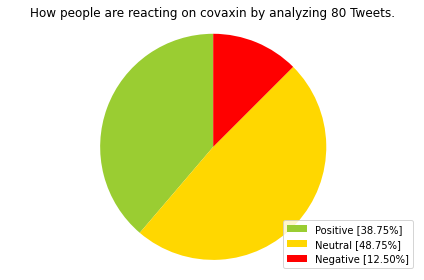

In [11]:
DownloadData()